In [26]:
import itertools
import sys
import os
import h5py
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.mlab as mlab
from matplotlib.ticker import MultipleLocator, LinearLocator, FormatStrFormatter, LogLocator, LogFormatterExponent
from matplotlib import cm
from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_style('darkgrid', {'axes.linewidth': '1', 'axes.edgecolor': '0.15'})
sns.set_style("ticks")
current_palette = sns.color_palette()

In [27]:
class mplot4d(object):
    def __init__(self, h5gridprefix = None, idb=0, idt=10, iqn = 26, iqp = 35):
        '''
        '''
        self.defpath = r'/home/ben/git/ndust/data/'

        self.h5gridprefix = h5gridprefix
        self.h5gridprefix = self.defpath + self.h5gridprefix

        # Read grid file
        self.gridfname = self.h5gridprefix + '.h5'
        self.gridfile =  h5py.File(self.gridfname, 'r')

        ## group volumes
        self.gvols = self.gridfile.get("Volume_sections")
        self.vifaces = np.array(self.gvols.get("Interfaces"))

        ## interfaces in diameters nm
        self.vifaces_diam = np.power(6.0*self.vifaces/np.pi, 1.0/3.0)*1E9

        ## WARNING diameter pivots in nanometres
        self.vpivots = np.array(self.gvols.get("Volumes"))

        ## pivots in diameters
        self.dpivots = np.array(self.gvols.get("Diameters"))*1E9

        ## group charges
        self.gchgs = self.gridfile.get("Charge_sections")

        self.qpivots = np.array(self.gchgs.get("Charges"))
        #self.qifaces = np.append()
        #np.array(self.gchgs.get("qifaces"))

        self.idb = []
        self.idt = []
        self.iqn = []
        self.iqp = []
        self.set_grid(idb, idt, iqn, iqp)

        self.gcoagulation = self.gridfile.get("Coagulation_rate")
        self.gefactor = self.gridfile.get("Enhancement_factor")
        self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
        self.hatches=['/', *[None]*(len(self.loglevels)-1)]
        self.hsize = []
        self.vsize = []

    def set_grid(self, idb, idt, iqn, iqp):
        self.idb = idb# index for minimum diameter
        self.idt = idt# index for maximum diameter
        self.iqn = iqn# index for negative charges
        self.iqp = iqp# index for positive charges
        # make grid
        self.X, self.Y = np.meshgrid(self.dpivots[idb:idt], self.qpivots[iqn:iqp])
        self.extents_linear = [0, len(self.dpivots[idb:idt]), 0, len(self.qpivots[iqn:iqp])]

    def get(self, name):
        efactor = np.array(self.gefactor.get(name))
        # get one dataset for testing    
        result = np.array(self.gcoagulation.get(name))
        res_gt_0 = result > 0
        log10res = np.zeros_like(result)
        log10res[res_gt_0] = np.log10(result[res_gt_0])
        return result, log10res, efactor

    def close(self):
        self.gridfile.close()

    def plot_fcontours(self, ax, data, levelsf=None, cmap=cm.plasma):
        """
        """
        if levelsf is None:
            levelsf = np.arange(1, 18, 2)

        norm = mpl.colors.Normalize(vmin=levelsf[0], vmax=levelsf[-1])
        
        # restrict data to grid
        datagrid = data[self.iqn:self.iqp, self.idb:self.idt]
#     self.axis(axislabel)
#     self.minorticks(fig)


#     CSF = ax.pcolormesh(X, Y, data, cmap=cmap)#,
#                       #extent=self.extents_linear)

#         CSF = ax.contourf(self.X[25:], self.Y[25:], data[25:], levelsf, cmap=cmap, origin='lower', norm=norm,
#                       extent=self.extents_linear)
#         CS = ax.contour(self.X[25:], self.Y[25:], data[25:], levels=levelsf, origin='lower',
#                     colors='k', linewidths=1.5)
        CSF = ax.contourf(self.X, self.Y, datagrid, levelsf, cmap=cmap,
                          origin='lower', norm=norm, extent=self.extents_linear,
                          hatches=self.hatches, extend='max')
        CS = ax.contour(self.X, self.Y, datagrid, levels=levelsf, origin='lower',
                        colors='k', linewidths=1.5)
        return CSF, CS
    def plot(self, llist, qlist, levelsf=np.logspace(0, 3, 20), xaxticks=None,
             yaxticks=None, filename='name', hsize=None, vsize=None):
        data = []
        
        for ll in llist:
            for ql in qlist:
                # iterate in datasets of gefactor
                for ds in self.gefactor.keys():
                    lp = self.gefactor.get(str(ds)).attrs.get('l')
                    qp = self.gefactor.get(str(ds)).attrs.get('q')
                    if(ll==lp and ql==qp):
                        #print(ll, ql)
                        data.append(np.array(self.gefactor.get(str(ds))))
                        #print(np.array(m4d.gefactor.get(str(ds))).shape)
#         data.append(self.get(rl)[2])
        if not hsize:
            self.hsize = len(qlist)*4.5
        else:
            self.hsize = hsize
        if not vsize:
            self.vsize = len(llist)*3.5
        else:
            self.vsize = vsize
        #hsize = len(qlist)*4.5/3.5
        fig, axes = plt.subplots(nrows=len(qlist), ncols=len(llist), figsize=(self.hsize, self.vsize))
#     plt.setp(axes.flat, xticks=[], yticks=[])

        for ax in axes.flat:
            # Hide all ticks and labels
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

#         # Set up ticks only on one side for the "edge" subplots...
#         if ax.is_first_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_last_col():
#             ax.yaxis.set_ticks_position('left')
#         if ax.is_first_row():
#             ax.xaxis.set_ticks_position('bottom')
#         if ax.is_last_row():
#             ax.xaxis.set_ticks_position('bottom')
            
        i=0
        for col, l in zip(axes.T, llist):
            for ax, q in zip(col, qlist):        
                CSF, CS = self.plot_fcontours(ax, data[i], levelsf=self.loglevels, cmap=cm.gist_heat_r)
                i = i+1

    # for ax, r in zip(axes[0], r1):    
    #     for ax, q in zip(axes[:, -1], q1):
    #         plot_fcontours(ax, m4d.X, m4d.Y, ef28, levelsf=np.logspace(0, 3, 20))
    # Label rows and columns

#     for ax, l in zip(axes[0], llist):
#         ax.set_title(str(self.dpivots[l]), size=14)
#         ax.yaxis.set_visible(True)

#     for ax, q in zip(axes[:, -1], qlist):
#         ax.set_ylabel(str(self.qpivots[q]), size=14)
#         ax.yaxis.set_label_position("right")
#         ax.get_yaxis().set_ticks([])
#         ax.yaxis.set_visible(True)


#     for ax, q in zip(axes[:, 0], qlist):
#         ax.set_ylabel('Charge of particle 1', size=14)
#         #ax.yaxis.set_label_position("left")
#         ax.yaxis.set_ticks_position('left')
#         ax.yaxis.set_visible(True)
        
#     for ax, l in zip(axes[len(llist)-1], llist):
#         ax.xaxis.set_ticks_position('bottom')
#         ax.set_xlabel('Diameter of particle 1', size=14)
#         ax.xaxis.set_visible(True)
        axes[len(col)-1, 0].xaxis.set_visible(True)
        axes[len(col)-1, 0].set_xlabel('Diameter of particle 1 (nm)', size=16)
        axes[len(col)-1, 0].yaxis.set_visible(True)
        axes[len(col)-1, 0].set_ylabel('Charge of particle 1 (e)', size=16)
        axes[len(col)-1, 0].yaxis.set_ticks_position('left')
        for ax in axes.flat:
            ax.xaxis.set_visible(True)
            ax.yaxis.set_visible(True)
            ax.xaxis.set_ticks_position('bottom')
            ax.yaxis.set_ticks_position('left')
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            ax.set_yticks(self.Y[:, 0])
            if xaxticks:
                ax.set_xticks(xaxticks)
            if yaxticks:
                ax.set_yticks(yaxticks)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
            #ax.get_xaxis().set_tick_params(direction='out', width=5)
            #ax.get_yaxis().set_tick_params(direction='out', width=1)
                
        for ax, l in zip(axes[0], llist):
            ax.set_title('{:.1f}'.format((self.dpivots[l])), size=16)
            ax.yaxis.set_visible(True)

        for ax, q in zip(axes[:, -1], qlist):
            ax.set_ylabel('{:+.0f}'.format((self.qpivots[q])), size=16, rotation=270, labelpad=20)
            ax.yaxis.set_label_position("right")
            ax.xaxis.set_visible(True)
            for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
        
# #     Turn on the proper x or y axes ticks.
#     for i, j in zip(range(numvars), itertools.cycle((-1, 0))):
#         axes[j,i].xaxis.set_visible(True)
#         axes[i,j].yaxis.set_visible(True)

#     print(axes)
#     [axes[len(llist)-1, j].xaxis.set_visible(True) for j in llist]
# fig.colorbar(im, ax=axes.ravel().tolist())
        plt.gcf().text(0.3, 0.92,"Diameter of particle 2 (nm)", ha="left", fontsize=20)
        plt.gcf().text(0.72, 0.64,"Charge of particle 2 (e)", ha="left", fontsize=20, rotation=-90)
        CB = fig.colorbar(CSF, ax=axes.ravel().tolist(), pad=0.12)
        #    CB.ax.set_ylabel(axislabel[2], fontsize=self.xc.label_fontsize1)
        #     CB.ax.tick_params(labelsize=self.xc.tick_fontsize)
        CB.add_lines(CS)
        CB.ax.set_ylabel('Enhancement factor', rotation=270, fontsize=20, labelpad=20)
        CB.ax.tick_params(labelsize=14)

        #     plt.suptitle("Radii of particle 2")
        plt.savefig(filename+'.eps')
        plt.show()
        #
    def plot_vs_charge(self, d1_index=0, d2_index=0, q2_index=0, filename='name', q1_indices=None, leg=True):
        data = []
        
        if np.size(q1_indices)==0:
            q1_indices = np.arange(len(self.qpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]))
                data= np.array(self.gefactor.get(str(ds)))[q1_indices,d1_index]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        ax.bar(self.qpivots[q1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        if leg:
            text = r"$d_1=$"+str(self.dpivots[d1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
            ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
            #plt.tight_layout()
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Charge of particle 1 (e)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps', bbox_inches='tight')
        plt.show()
        return self.qpivots[q1_indices], data
        #
    def plot_vs_diam(self, q1_index=0, d2_index=0, q2_index=0, filename='name', d1_indices=None):
        data = []
        
        if np.size(d1_indices)==0:
            d1_indices = np.arange(len(self.dpivots))

        # iterate in datasets of gefactor
        for ds in self.gefactor.keys():
            lp = self.gefactor.get(str(ds)).attrs.get('l')
            qp = self.gefactor.get(str(ds)).attrs.get('q')
            if(d2_index==lp and q2_index==qp):
                #print(np.shape(np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]))
                data= np.array(self.gefactor.get(str(ds)))[q1_index, d1_indices]
                #print(np.array(m4d.gefactor.get(str(ds))).shape)
        fig, ax = plt.subplots(1, 1, figsize=(7, 5.85))
        #ax.plot(self.dpivots[d1_indices], data, lw=3)
        ax.bar(self.dpivots[d1_indices], data)
        #     plt.suptitle("Radii of particle 2")
        #plt.savefig(filename+'.eps')
        text = r"$q_1=$"+str(self.qpivots[q1_index])+ " nm\n"+ r"$d_2=$"+str(self.dpivots[d2_index])+ " nm\n"+r"$q_2=$"+str(int(self.qpivots[q2_index]))
        ax.text(0.5, 0.5, text, horizontalalignment='right', verticalalignment='top',
                 multialignment='left', fontsize=20, transform=ax.transAxes)
        #lt.yscale('symlog')
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(20)
        ax.set_xlabel('Diameter of particle 1 (nm)', size=20)
        ax.set_ylabel('Enhancement factor', size=20)
#         print(self.qpivots[q1_indices])
        plt.savefig(filename+'.eps')
        plt.show()
        return self.dpivots[d1_indices], data

In [28]:
#m4d = mplot4d("grid-linear-IPA-force-50-adjusted")
m4d = mplot4d("grid-linear-IPA-force-50")
# m4d2 = mplot4d("grid-geom-IPA-force-50-adjusted")
#m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
m4d2 = mplot4d("grid-geom-IPAMPC-force-50")
m4dmpc = mplot4d("grid-linear-MPC20")
m4dmpc2 = mplot4d("grid-geom-MPC20")
m4dc = mplot4d("grid-linear-coulomb")
m4dc2 = mplot4d("grid-geom-coulomb")

In [29]:
len(m4d.vpivots)

50

In [30]:
len(m4d.qpivots)

36

In [31]:
#m4d = mplot4d("q5-grid-geom-MPCIPA25")
#m4d = mplot4d("q6-grid-geom-MPCIPA25")

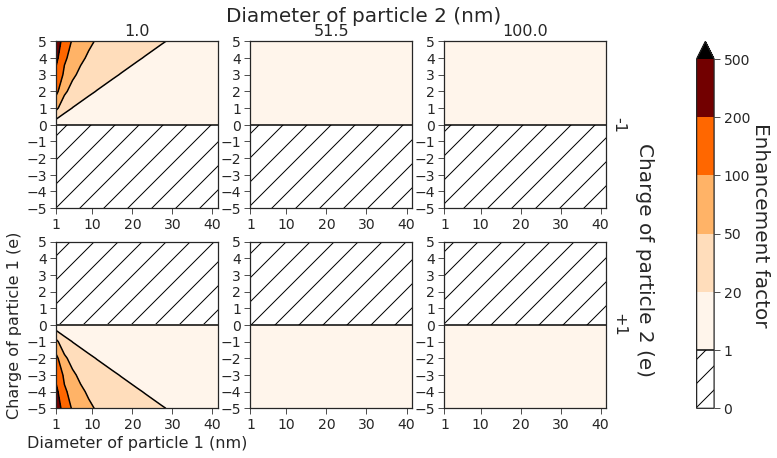

In [32]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 31]
m4dc.set_grid(0, 21, 25, 36)
m4dc.plot(ll, ql, filename='fig3', vsize=3*2.25, hsize=4.5*3, xaxticks=[1, *np.arange(10, 50, 10)])

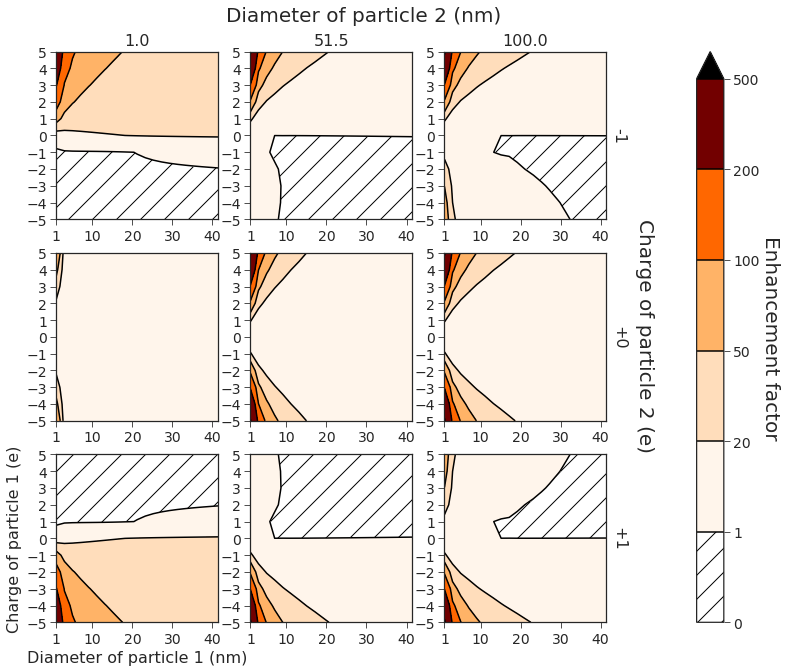

In [105]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 30, 31]
m4d.set_grid(0, 21, 25, 36)
m4d.plot(ll, ql, filename='fig9', xaxticks=[1, *np.arange(10, 50, 10)])

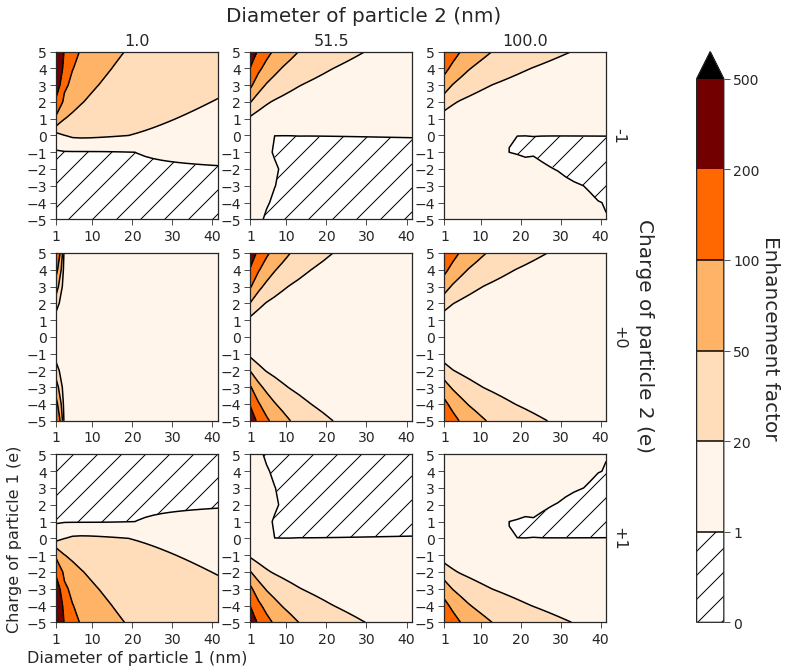

In [104]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[29, 30, 31]
m4dmpc.set_grid(0, 21, 25, 36)
m4dmpc.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
m4dmpc.hatches=['/', *[None]*(len(m4dmpc.loglevels)-1)]
m4dmpc.plot(ll, ql, filename='fig4', xaxticks=[1, *np.arange(10, 50, 10)])

In [57]:
max(m4dmpc.gefactor)

'999'

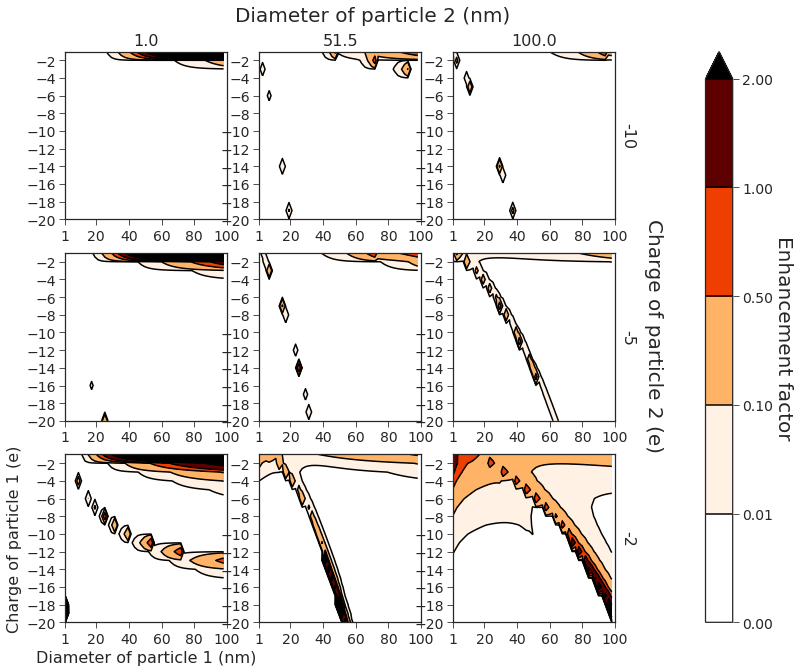

In [71]:
# ll=[0, 1, 2]
ll=[0, 25, 49]
ql=[20, 25, 28]
m4dmpc.set_grid(0, 49, 10, 30)
#self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
#self.hatches=['/', *[None]*(len(self.loglevels)-1)]
m4dmpc.loglevels = np.array([0, 0.01, 0.1, 0.5, 1, 2])
#m4dmpc.hatches=['\\', *[None]*(len(m4dmpc.loglevels)-1)]
#m4dmpc.loglevels = np.array([1e-10, 0.1, 0.5, 10.0])
#m4dmpc.hatches=['/', '/', '/', '/', '/', None, None]
m4dmpc.hatches=[None, None, None, None, None, None]
m4dmpc.plot(ll, ql, filename='fig5', xaxticks=[1, *np.arange(20, 120, 20)],
            yaxticks=[*np.arange(-20, -1, 2)])

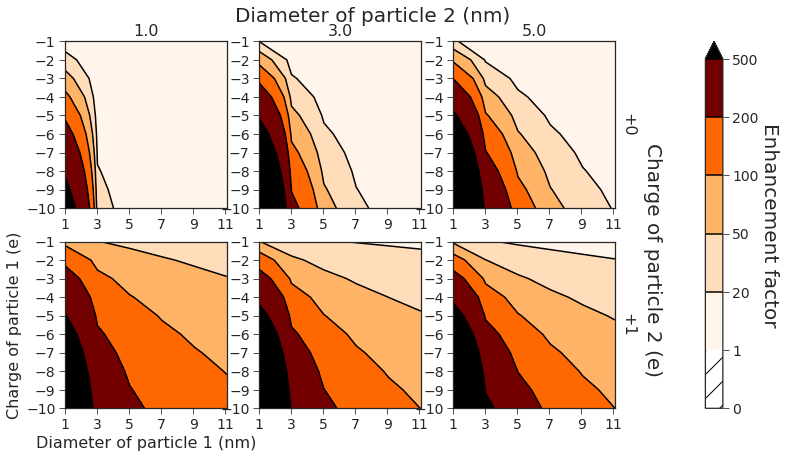

In [108]:
# ll=[0, 1, 2]
#ll=[0, 25, 49]
#ql=[29, 31]
#m4dc.set_grid(0, 21, 25, 36)
#m4dc.plot(ll, ql, filename='fig3', vsize=3*2.25, hsize=4.5*3, xaxticks=[1, *np.arange(10, 50, 10)])

# ll=[0, 1, 2]
ll=[0, 1, 2]
ql=[30, 31]
m4dmpc.set_grid(0, 6, 20, 30)
m4dmpc.plot(ll, ql, filename='fig6', vsize=3*2.25, hsize=4.5*3, xaxticks=[*np.arange(1, 13, 2)])

In [ ]:
m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))

In [ ]:
70*.7/12

In [ ]:
m4d.plot_vs_charge(0, 10, 29, 'name', np.arange(15, 31))
m4dmpc.plot_vs_charge(0, 10, 29, 'name', np.arange(15, 31))

m4d.plot_vs_charge(0, 5, 29, 'name', np.arange(25, 31))
m4dmpc.plot_vs_charge(0, 5, 29, 'name', np.arange(25, 31))

m4d2.plot_vs_charge(0, 42, 29, 'name', np.arange(15, 31))#geom
m4dmpc2.plot_vs_charge(0, 42, 29, 'name', np.arange(15, 31))#geom

m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))
m4dmpc.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))

m4d2.plot_vs_diam(29, 5, 28, 'name', np.arange(0, 49))
m4dmpc2.plot_vs_diam(29, 5, 28, 'name', np.arange(0, 49))


In [ ]:
m4d.plot_vs_charge(0, 0, 30, 'name', np.arange(26, 35))
#m4d2.plot_vs_charge(1, 0, 30, 'name', np.arange(26, 35))
m4dmpc.plot_vs_charge(0, 0, 30, 'neutral', np.arange(26, 35))
m4d.plot_vs_charge(1, 1, 30, 'name', np.arange(26, 35))
m4dmpc.plot_vs_charge(1, 1, 30, 'neutral', np.arange(26, 35))

#m4d.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 42))
#m4d2.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 49))
#m4dmpc.plot_vs_diam(29, 0, 28, 'name', np.arange(0, 42))

In [ ]:
#m4d = mplot4d("grid-geom-IPA-force")

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[28, 29, 31]
m4d.set_grid(0, 49, 26, 35)
m4d.plot(ll, ql)

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure4')

In [ ]:
m4d.dpivots[42]

In [ ]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4d.set_grid(0, 50, 26, 35)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure5')

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 20]
ql=[25, 26, 27]
m4d.set_grid(0, 50, 25, 31)
# set xaxis
m4d.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)])#, filename='figure5')

In [ ]:
ll=[4, 14, 29]
#ql=[28, 29, 31]
ql=[0, 14, 31]
m4d.qneg = 0
m4d.plot(ll, ql)

In [ ]:
#m4d.close()

In [ ]:
m4d.dpivots

In [ ]:
m4dmpc.dpivots

In [ ]:
m4d2.dpivots

In [ ]:
m4dmpc2.dpivots

In [ ]:
ll=[0, 1, 3]
ql=[28, 29, 31]
m4dmpc2.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc2.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)])

In [ ]:
ll=[5, 25, 49]
ql=[28, 29, 31]
m4dmpc2.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc2.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figurex')

In [ ]:
# ll=[0, 1, 2]
# ll=[0, 2, 19]
# ql=[28, 29, 31]
# m4dmpc.set_grid(0, 50, 26, 35)

ll=[0, 2, 20]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 49, 26, 35)

# set xaxis
#m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure2')
m4dmpc.plot(ll, ql, filename='figure2')

In [ ]:
# ll=[0, 1, 2]
ll=[25, 42, 49]
ql=[28, 29, 31]
m4dmpc.set_grid(0, 50, 26, 35)
# set xaxis
m4dmpc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure3')

In [ ]:
#m4d2.close()

In [ ]:
# ll=[0, 1, 2]
ll=[0, 2, 19]
ql=[28, 29, 31]
m4dc.set_grid(0, 50, 26, 35)
# set xaxis
m4dc.plot(ll, ql, xaxticks=[1, *np.arange(20, 120, 20)], filename='figure1')


In [ ]:
m4d2.dpivots

In [ ]:
m4d2.qpivots

In [25]:
m4d.close()
m4d2.close()
m4dmpc.close()
m4dmpc2.close()
m4dc.close()

In [76]:
spg_ipampc = mplot4d("special-grid-IPAMPC")
spg_mpc = mplot4d("special-grid-MPC")


In [77]:
len(spg_ipampc.vpivots)

40

In [78]:
len(spg_mpc.vpivots)

40

In [79]:
len(spg_ipampc.qpivots)

50

In [80]:
len(spg_mpc.qpivots)

50

In [81]:
spg_mpc.dpivots

array([   1.        ,    1.5       ,    2.        ,    2.5       ,
          3.        ,    3.5       ,    4.        ,    4.5       ,
          5.        ,    5.5       ,    6.        ,    6.5       ,
          7.        ,    7.49999952,    8.        ,    8.5       ,
          9.        ,    9.5       ,   10.        ,   90.        ,
         90.5       ,   91.        ,   91.5       ,   92.        ,
         92.5       ,   93.        ,   93.5       ,   94.        ,
         94.5       ,   95.        ,   95.5       ,   96.        ,
         96.5       ,   97.        ,   97.5       ,   98.        ,
         98.5       ,   99.        ,   99.5       ,  100.        ], dtype=float32)

In [82]:
spg_mpc.qpivots

array([-296., -295., -294., -293., -292., -291., -290., -289., -288.,
       -287., -286., -285., -284., -283., -282., -281., -280., -279.,
       -278., -277., -276., -275., -274., -273., -272., -271., -270.,
       -269., -268., -267.,  -14.,  -13.,  -12.,  -11.,  -10.,   -9.,
         -8.,   -7.,   -6.,   -5.,   -4.,   -3.,   -2.,   -1.,    0.,
          1.,    2.,    3.,    4.,    5.], dtype=float32)

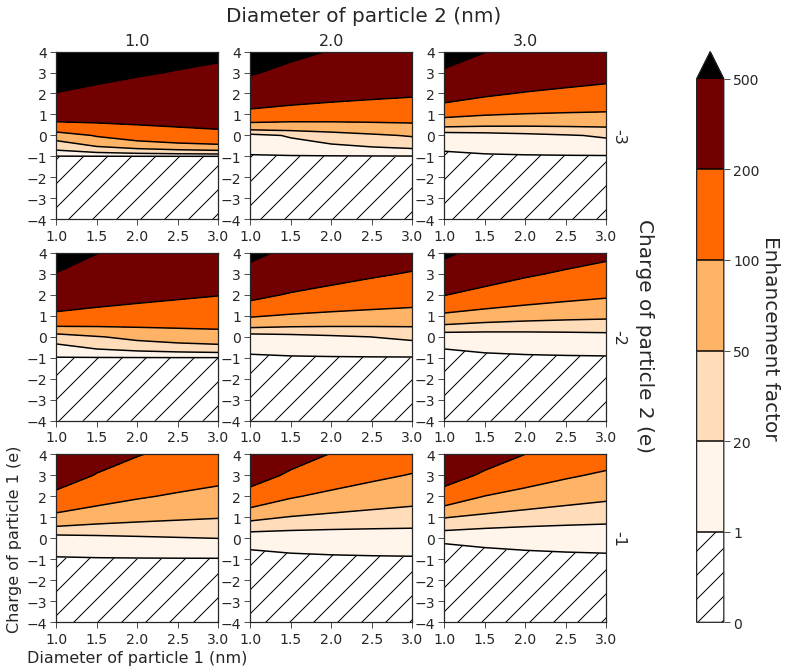

In [90]:
# ll=[0, 1, 2]
ll=[0, 2, 4]
ql=[41, 42, 43]
spg_mpc.set_grid(0, 5, 40, 49)
spg_mpc.plot(ll, ql, filename='fig7')

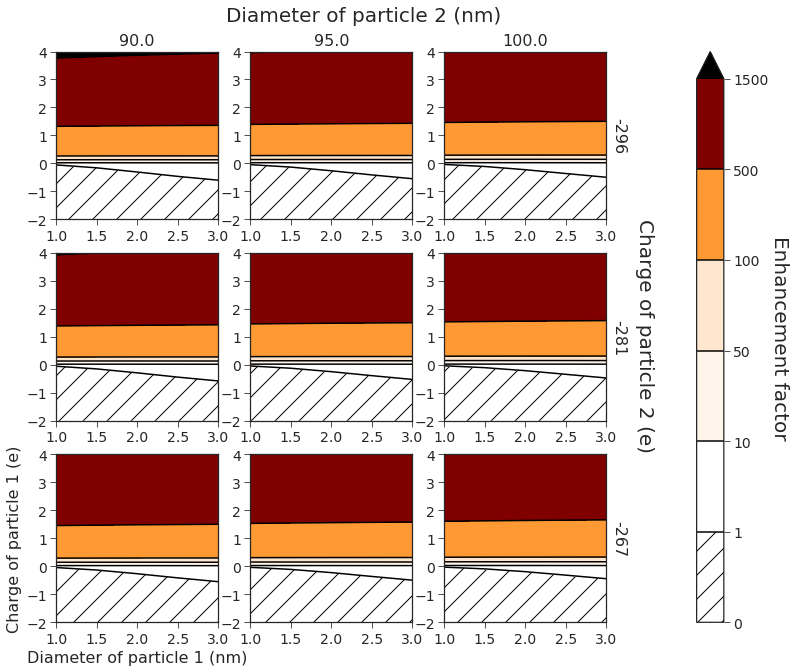

In [106]:
# ll=[0, 1, 2]
ll=[19, 29, 39]
ql=[0, 15, 29]
spg_mpc.set_grid(0, 5, 42, 49)
#self.loglevels = np.array([0, 1, 20, 50, 100, 200, 500])
#self.hatches=['/', *[None]*(len(self.loglevels)-1)]
spg_mpc.loglevels = np.array([0, 1, 10, 50, 100, 500, 1500])
spg_mpc.plot(ll, ql, filename='fig8')

In [85]:
spg_ipampc.qpivots[30]

-14.0